# Project Overview
This notebook demonstrates a fully automated Python pipeline for quantitative analysis of collagen fiber images captured with polarized light microscopy. The workflow includes preprocessing, outlier removal, statistical testing (ANOVA, PCA), and the generation of publication-ready visualizations.


# Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Data Loading and Preprocessing

In [ ]:
# read
df = pd.read_csv("/content/Picrosirius_WB_AllParams.csv")
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation
0,46_MXD_WB_L1,7.5,62.8,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,6.8,51.5,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,7.7,69.2,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,7.4,65.4,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,6.7,56.7,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [ ]:
# convert from pixels to microns
conversion_factor = 0.124 # ~0.124 µm/pixel

df["Length"] = df["Length"] * conversion_factor
df["Width"] = df["Width"] * conversion_factor
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation
0,46_MXD_WB_L1,0.9300,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,0.8432,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,0.9548,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,0.9176,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,0.8308,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [ ]:
# create new "Condition" column
df['Condition'] = df['Slide'].str.split('_').str[1]
df.head()

# create new 'Replicate' column
df['Replicate'] = df['Slide'].str.split('_').str[0]
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation,Condition,Replicate
0,46_MXD_WB_L1,0.9300,7.7872,0.94,127.1,105,692,0.59,0.5211,0.43,152.0,MXD,46
1,46_MXD_WB_L1_2,0.8432,6.3860,0.95,119.8,41,454,0.66,0.6196,0.37,141.7,MXD,46
2,46_MXD_WB_L2,0.9548,8.5808,0.96,56.8,50,541,0.71,0.4178,0.43,27.1,MXD,46
3,46_MXD_WB_L2_2,0.9176,8.1096,0.93,133.0,248,946,0.77,0.7035,0.50,146.8,MXD,46
4,46_MXD_WB_R1,0.8308,7.0308,0.94,124.9,51,502,0.60,0.4512,0.37,144.8,MXD,46


# Outlier Removal

In [ ]:
# compare before and after removing outliers
df.describe()

,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.845320,7.803097,0.948974,104.010256,93.683761,647.914530,0.812650,0.743420,0.556923,105.143590
std,0.047562,1.536901,0.010536,46.349470,82.188246,231.601381,0.125199,0.116813,0.175231,55.593178
min,0.731600,4.786400,0.910000,30.500000,6.000000,242.000000,0.100000,0.166100,0.030000,13.400000
25%,0.806000,6.658800,0.940000,43.500000,34.000000,486.000000,0.770000,0.717100,0.430000,33.500000
50%,0.843200,7.613600,0.950000,133.000000,70.000000,620.000000,0.830000,0.755500,0.530000,139.000000
75%,0.868000,8.556000,0.960000,138.300000,111.000000,750.000000,0.910000,0.813700,0.700000,146.900000
max,1.016800,12.288400,0.970000,149.600000,352.000000,1328.000000,0.980000,0.917900,0.920000,161.700000


In [ ]:
# filter outliers function (+/- 2 STD)
# returns list of indices corresponding to outliers in a specific column
def get_outliers_col(df, column, n_std=2):
    mean = df[column].mean()
    std = df[column].std()
    lower = mean - n_std * std
    upper = mean + n_std * std
    ls = df.index[(df[column] <= lower) | (df[column] >= upper)]
    return ls

In [ ]:
# function that removes rows containing outliers by index
def remove_outliers(df, indices):
  df_filtered = df.drop(index = indices)
  return df_filtered

In [ ]:
# apply function
# create a new df for each filtered column
filtered_dfs = {}
cols_to_filter = ['Length', 'Width', 'AlignmentCA', 'Kurtosis', 'FeatNumCT']
for col in cols_to_filter:
  outliers = get_outliers_col(df, col)
  filtered_df = remove_outliers(df, outliers)
  filtered_dfs[col] = filtered_df

# compare before and after
filtered_dfs['Length'].describe()

,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,AlignmentCA,AlignmentMF,Kurtosis,Orientation
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,0.844639,7.625446,0.948839,106.923214,90.714286,637.133929,0.807946,0.739404,0.554464,108.427679
std,0.048463,1.310594,0.010548,45.211084,81.455059,226.070207,0.125749,0.117352,0.175514,54.539460
min,0.731600,4.786400,0.910000,30.500000,6.000000,242.000000,0.100000,0.166100,0.030000,13.400000
25%,0.806000,6.606100,0.940000,49.350000,32.500000,476.000000,0.760000,0.712700,0.430000,36.250000
50%,0.843200,7.576400,0.950000,133.900000,66.000000,593.500000,0.820000,0.754950,0.530000,139.950000
75%,0.868000,8.500200,0.960000,138.425000,107.250000,734.500000,0.900000,0.809725,0.700000,147.300000
max,1.016800,10.837600,0.970000,149.600000,352.000000,1328.000000,0.980000,0.917900,0.920000,161.700000


In [ ]:
# create dfs that match slide number to condition
df_Length = filtered_dfs['Length'].groupby(['Replicate', 'Condition'])[
    'Length'].mean().reset_index()
df_Width = filtered_dfs['Width'].groupby(['Replicate', 'Condition'])[
    'Width'].mean().reset_index()
df_Alignment = filtered_dfs['AlignmentCA'].groupby(['Replicate', 'Condition'])[
    'AlignmentCA'].mean().reset_index()
df_Kurtosis = filtered_dfs['Kurtosis'].groupby(['Replicate', 'Condition'])[
    'Kurtosis'].mean().reset_index()
df_FeatNumCT = filtered_dfs['FeatNumCT'].groupby(['Replicate', 'Condition'])[
    'FeatNumCT'].mean().reset_index()

df_sorted_Length = df_Length.sort_values('Condition')
print(df_sorted_Length)

   Replicate Condition     Length
1         47       AXD   7.603108
10        56       AXD   7.576400
11        57       AXD   6.471029
15        61       AXD   7.792514
0         46       MXD   7.608286
4         50       MXD   7.215250
5         51       MXD   7.231267
14        60       MXD   5.792571
2         48       PXD   6.767920
6         52       PXD   7.918286
12        58       PXD   7.192000
13        59       PXD   8.304457
3         49       SXD   8.682255
7         53       SXD   9.169800
8         54       SXD   7.322200
9         55       SXD  10.251700


In [ ]:
print(df_Length.groupby('Condition')['Length'].mean())
print(df_Length.groupby('Condition')['Length'].std())

Condition
AXD    7.360763
MXD    6.961843
PXD    7.545666
SXD    8.856489
Name: Length, dtype: float64
Condition
AXD    0.600907
MXD    0.800393
PXD    0.693921
SXD    1.215069
Name: Length, dtype: float64


In [ ]:
name_map = {
    'MXD': 'MSC',
    'SXD': 'Splint',
    'AXD': 'Acellular',
    'PXD': 'Pixel Graft'
}

df_Length['Condition'] = df_Length['Condition'].map(name_map)
df_Width['Condition'] = df_Width['Condition'].map(name_map)
df_Alignment['Condition'] = df_Alignment['Condition'].map(name_map)
df_Kurtosis['Condition'] = df_Kurtosis['Condition'].map(name_map)
df_FeatNumCT['Condition'] = df_FeatNumCT['Condition'].map(name_map)

# Statistical Testing
* ANOVA, Tukey's HSD  

In [ ]:
# Set the source DataFrame and dependent variable
df_source = df_FeatNumCT
dependent_variable = "FeatNumCT"

# Extract groups based on Condition
M = df_source[df_source["Condition"] == "MSC"][dependent_variable]
A = df_source[df_source["Condition"] == "Acellular"][dependent_variable]
P = df_source[df_source["Condition"] == "Pixel Graft"][dependent_variable]
S = df_source[df_source["Condition"] == "Splint"][dependent_variable]

# Run one-way ANOVA
f_stat, p_val = f_oneway(M, A, P, S)
print(f"F-statistic: {f_stat}, p-value: {p_val}")

F-statistic: 4.368849469605775, p-value: 0.026831623773113357


In [ ]:
# Tukey's HSD
data = pd.concat([M, A, P, S], ignore_index=True)
labels = (
    ['MSC'] * len(M) + ['Acellular'] * len(A) +
    ['Pixel Graft'] * len(P) + ['Splint'] * len(S)
)
tukey = pairwise_tukeyhsd(endog=data, groups=labels, alpha=0.05)
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1      group2   meandiff p-adj   lower    upper   reject
----------------------------------------------------------------
  Acellular         MSC   -6.125 0.9966 -93.4921  81.2421  False
  Acellular Pixel Graft   27.481 0.7877 -59.8862 114.8481  False
  Acellular      Splint  89.0476 0.0453   1.6805 176.4147   True
        MSC Pixel Graft   33.606 0.6721 -53.7612 120.9731  False
        MSC      Splint  95.1726 0.0315   7.8055 182.5397   True
Pixel Graft      Splint  61.5667 0.2103 -25.8004 148.9338  False
----------------------------------------------------------------


# Data Visualization

/tmp/ipython-input-3347935001.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',
/tmp/ipython-input-3347935001.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',


Tick interval: 2.0


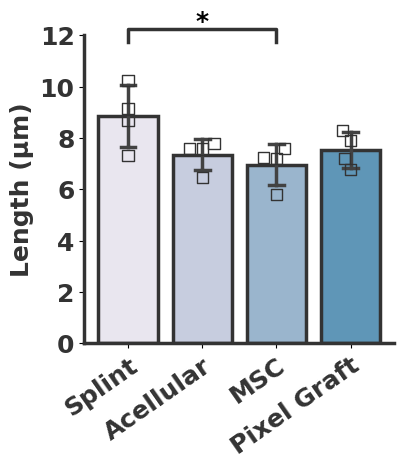

In [42]:
# Length plot
dependent_variable = "Length"
data = df_Length
desired_order = ['Splint', 'Acellular', 'MSC', 'Pixel Graft']
plt.figure(figsize=(4,4))
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]
ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',
            capsize=0.2, order = desired_order, palette=custom_palette, legend=False,
            edgecolor = '0.2', lw = 2.5, errwidth = 2.5)
max_val = data[dependent_variable].max()

# plot points on the bar graph
marker_size = 8
linewidth_size = 1
ax = sns.swarmplot(data = data, x = 'Condition', y = dependent_variable,
                   marker = "s", fc = 'None', edgecolor = '0.2',
                   linewidth = linewidth_size, size=marker_size)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# rotate labels
font_size = 18
plt.xticks(size = font_size, rotation = 35, rotation_mode = 'anchor', ha = 'right',
           weight = 'bold', color = '0.2')
# plt.xticks([])
plt.yticks(size = font_size, weight = 'bold', color = '0.2')
ax.set_xlabel(None)
ax.set_ylabel("Length (µm)", size = font_size, weight = 'bold', color = '0.2')

ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)
interval = interval/2

plt.plot([0,0,2,2],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval, max_val + 1.5*interval],
         lw=2.5, color='0.2', clip_on=False)

alignment = 'center'
size = 18
plt.text(x=1, y=max_val + 2*interval + interval/50, s="*", ha=alignment,
         size=size, weight='bold')

plt.ylim(top = 12)

plt.savefig(f"{dependent_variable}.png", bbox_inches = 'tight', dpi = 600,
            facecolor = ax.get_facecolor())

/tmp/ipython-input-3406832962.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',
/tmp/ipython-input-3406832962.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',


Tick interval: 0.2


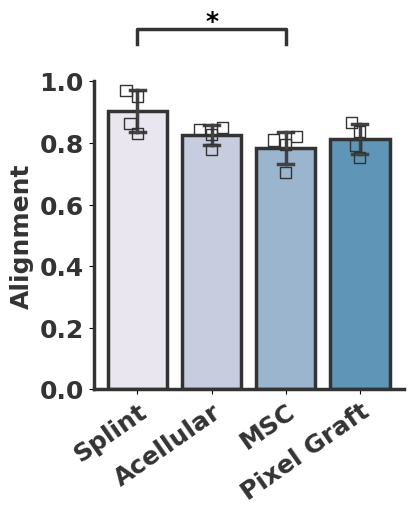

In [44]:
# Alignment plot
dependent_variable = "AlignmentCA"
data = df_Alignment
desired_order = ['Splint', 'Acellular', 'MSC', 'Pixel Graft']
plt.figure(figsize=(4,4))
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]
ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',
            capsize=0.2, order = desired_order, palette=custom_palette, legend=False,
            edgecolor = '0.2', lw = 2.5, errwidth = 2.5)
max_val = data[dependent_variable].max()

# plot points on the bar graph
marker_size = 8
linewidth_size = 1
ax = sns.swarmplot(data = data, x = 'Condition', y = dependent_variable,
                   marker = "s", fc = 'None', edgecolor = '0.2',
                   linewidth = linewidth_size, size=marker_size)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# rotate labels
font_size = 18
plt.xticks(size = font_size, rotation = 35, rotation_mode = 'anchor', ha = 'right',
           weight = 'bold', color = '0.2')
# plt.xticks([])
plt.yticks(size = font_size, weight = 'bold', color = '0.2')
ax.set_xlabel(None)
ax.set_ylabel("Alignment", size = font_size, weight = 'bold', color = '0.2')

ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)
interval = interval/2

plt.plot([0,0,2,2],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval, max_val + 1.5*interval],
         lw=2.5, color='0.2', clip_on=False)

alignment = 'center'
size = 18
plt.text(x=1, y=max_val + 2*interval + interval/50, s="*", ha=alignment,
         size=size, weight='bold')

plt.ylim(top = 1)

plt.savefig(f"{dependent_variable}.png", bbox_inches = 'tight', dpi = 600,
            facecolor = ax.get_facecolor())

/tmp/ipython-input-1307826362.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',
/tmp/ipython-input-1307826362.py:7: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',


Tick interval: 50.0


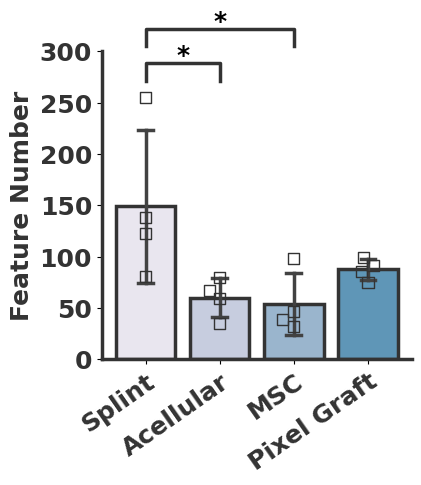

In [45]:
# Feature Number
dependent_variable = "FeatNumCT"
data = df_FeatNumCT
desired_order = ['Splint', 'Acellular', 'MSC', 'Pixel Graft']
plt.figure(figsize=(4,4))
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"]
ax = sns.barplot(data=data, x='Condition', y=dependent_variable, errorbar='sd',
            capsize=0.2, order = desired_order, palette=custom_palette, legend=False,
            edgecolor = '0.2', lw = 2.5, errwidth = 2.5)
max_val = data[dependent_variable].max()

# plot points on the bar graph
marker_size = 8
linewidth_size = 1
ax = sns.swarmplot(data = data, x = 'Condition', y = dependent_variable,
                   marker = "s", fc = 'None', edgecolor = '0.2',
                   linewidth = linewidth_size, size=marker_size)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
  ax.spines[axis].set_linewidth(2.5)
  ax.spines[axis].set_color('0.2')

# hide top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# rotate labels
font_size = 18
plt.xticks(size = font_size, rotation = 35, rotation_mode = 'anchor', ha = 'right',
           weight = 'bold', color = '0.2')
plt.yticks(size = font_size, weight = 'bold', color = '0.2')
ax.set_xlabel(None)
ax.set_ylabel("Feature Number", size = font_size, weight = 'bold', color = '0.2')

ticks = ax.get_yticks()
interval = ticks[1] - ticks[0]
print("Tick interval:", interval)
interval = interval/1.5

plt.plot([0,0,2,2],
         [max_val + 1.5*interval, max_val + 2*interval, max_val + 2*interval, max_val + 1.5*interval],
         lw=2.5, color='0.2', clip_on=False)
plt.plot([0, 0, 1, 1],
         [max_val + 0.5*interval, max_val + interval, max_val + interval, max_val + 0.5*interval],
         lw=2.5, color='0.2', clip_on=False)

alignment = 'center'
size = 18
plt.text(x=1, y=max_val + 2*interval + interval/50, s="*", ha=alignment,
         size=size, weight='bold')
plt.text(x=0.5, y=max_val + interval + interval/50, s="*", ha=alignment,
         size=size, weight='bold')

plt.ylim(top = 300)

plt.savefig(f"{dependent_variable}.png", bbox_inches = 'tight', dpi = 600,
            facecolor = ax.get_facecolor())